---
# [NideconvFitter](https://linescanning.readthedocs.io/en/latest/classes/fitting.html#linescanning.fitting.NideconvFitter)

This notebook illustrates how to perform a deconvolution using `nideconv` and specific classes from this repository. First, we read the data in with `linescanning.dataset.Dataset`, which formats our functional data and onset timings the way nideconv likes it. Then I show some useful functions to select specific portions of a larger dataframe. Then, we perform the fitting and do some plotting

In [1]:
# imports
from linescanning import dataset, plotting, utils
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/mnt/d/FSL/shared/spinoza/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False

/home/gjheij/anaconda3/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


220527-16:09:16,927 nipype.utils WARNING:
	 A newer version (1.8.1) of nipy/nipype is available. You are using 1.7.1


Load in some data. You could substitute this with the example data provided with the repository. However, when I did the deconvolution on that data the results didn't look good enough for illustrative purposes. So I have a different dataset here: 3 runs of a Size-Response experiment in which our target pRF was bombarded with flickering stimuli of 5 different sizes.

In [2]:
    # Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
ribbon      = (356,363)

run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file   = utils.get_file_from_substring("events.tsv", run_files)
func_file


['/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat',
 '/mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat']

Here we plop everything in `Dataset`, which will automatically format the functional data and onset timings for us

In [3]:
window = 19
order = 3

## window 5 TR poly 2
data_obj = dataset.Dataset(func_file,
                           deleted_first_timepoints=50,
                           deleted_last_timepoints=50,
                           tsv_file=exp_file,
                           standardization="psc",
                           use_bids=True,
                           verbose=True)

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_func

DATASET

FUNCTIONAL
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]
Preprocessing /mnt/d/FSL/shared/spinoza/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Cutting 50 volumes from beginning
 DCT-high pass filter [removes low frequencies <0.01 Hz]

EXPTOOLS
 1st 't' @153.63s
 Cutting 158.88s from onsets
 1st 't' @109.93s
 Cutting 115.18s from onsets
 1st 't' @117.54s
 Cutting 122.79s from onsets

DATASET: created
Fetching data

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
003     3   0.000   -13.891739  18.961037   2.063560   3.682375  18.408548   
            0.105     2.888107   1.986206   0.264144 -19.847315  10.156822   
            0.210    14.478707   3.458476 -10.143953  12.808430   2.470386   
            0.315    -0.892764   2.037525   9.948230  10.508978   2.991283   
            0.420    -2.172971 -12.968266  -5.167145  19.498407  -3.685570   
...                        ...        ...        ...        ...        ...   
        6   450.975 -17.279535  -2.477372  -3.926116   3.006363  -1.927710   
            451.080   6.059623  15.340543   0.604963  -5.547303   5.246913   
            451.185  -9.228765 -15.565098   1.942837 -14.227385  -6.210101   
            451.290  -3.713530  -3.111917 -11.907101  -3.710544  -9.821296   
            451.395  -3.663754  -0.976616  12.796629   7.261193  -0.584477   

                         vox 5      vox 6      vox 7     vox 8     vox 9  ...  \
subject run t                                                             ...   
003     3   0.000    -3.695518  -6.322670   7.888627 -0.710595  6.094122  ...   
            0.105    11.342180   0.616658   3.926539 -9.278136 -1.705915  ...   
            0.210    12.478614   1.801240  -9.651148  7.441664 -4.916453  ...   
            0.315    16.056644  15.093732   3.601110 -2.542460  8.589327  ...   
            0.420     3.078425   2.305973   1.143467  9.401453  5.093873  ...   
...                        ...        ...        ...       ...       ...  ...   
        6   450.975   2.022326   4.765296  -6.734014  9.385133 -2.454519  ...   
            451.080   2.117193  -1.010811   3.976870  6.112242  7.436466  ...   
            451.185  -4.854160  -2.776635 -15.307665  1.672268 -9.687460  ...   
            451.290  -4.560441   0.006092  -2.611202 -7.827675 -8.107227  ...   
            451.395   6.986260   1.348627  -6.136215  2.416396 -4.276877  ...   

                       vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                                
003     3   0.000    -5.610657   1.466882 -25.425249   9.925949  23.816406   
            0.105    37.625992  -1.024687  54.549576  65.410065  29.830610   
            0.210    18.496466 -39.420105 -26.193417  20.526684  30.854071   
            0.315   -19.457424  30.023706  -3.505743 -12.246126  12.542200   
            0.420    15.934170   0.570488 -42.262341  -0.495994  36.378086   
...                        ...        ...        ...        ...        ...   
        6   450.975 -21.043629  -3.231406   0.715935   4.999340  -0.382054   
            451.080 -20.298153  -3.651762  14.769506 -15.060788   6.571209   
            451.185 -29.944235 -13.122016  27.926327  20.926607  -4.315299   
            451.290 -18.581844 -18.917555 -12.296158  40.080978  26.049339   
            451.395  14.358282  12.810146  -8.563005  37.025917 -17.322523   

                       vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                               
003     3   0.000    36.882210  -6.540275 -36.774765 -35.853077   4.625607  
            0.105   -17.018139  42.048325  44.971848 -22.749884 -24.342083  
            0.210   -31.180561 -15.022355  -7.922816 -83.307953  12.106180  
            0.315    -0.922859  28.065704  36.624050 -30.900723   3.338301  
            0.420   -20.713203  11.566341 -47.377197 -33.735943 -26.920324  
...                        ...        ...        ...        ...        ...  
        6   450.975   3.886271  54.486858   8.198714   6.584823  11.246193  
            451.080  16.233110  57.221188 -47.112717 -17.041237  -8.584696  
            451.185   0.009978 -27.368498 -12.637245 -19.139153   9.449827  
            451.290  -5.964356  34.597633 -10.000515 -36.652924  27.440023  
            451.3

Now we have our data formatted the way `nideconv` likes it: the functional data is indexed by `subject`, `run`, and `t`, while the onset dataframe is indexed by `subject`, `run`, and `event_type`:

In [4]:
df_func.head()


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
003     3   0.000 -13.891739  18.961037   2.063560   3.682375  18.408548   
            0.105   2.888107   1.986206   0.264144 -19.847315  10.156822   
            0.210  14.478707   3.458476 -10.143953  12.808430   2.470386   
            0.315  -0.892764   2.037525   9.948230  10.508978   2.991283   
            0.420  -2.172971 -12.968266  -5.167145  19.498407  -3.685570   

                       vox 5      vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
003     3   0.000  -3.695518  -6.322670  7.888627 -0.710595  6.094122  ...   
            0.105  11.342180   0.616658  3.926539 -9.278136 -1.705915  ...   
            0.210  12.478614   1.801240 -9.651148  7.441664 -4.916453  ...   
            0.315  16.056644  15.093732  3.601110 -2.542460  8.589327  ...   
            0.420   3.078425   2.305973  1.143467  9.401453  5.093873  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000  -5.610657   1.466882 -25.425249   9.925949  23.816406   
            0.105  37.625992  -1.024687  54.549576  65.410065  29.830610   
            0.210  18.496466 -39.420105 -26.193417  20.526684  30.854071   
            0.315 -19.457424  30.023706  -3.505743 -12.246126  12.542200   
            0.420  15.934170   0.570488 -42.262341  -0.495994  36.378086   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
003     3   0.000  36.882210  -6.540275 -36.774765 -35.853077   4.625607  
            0.105 -17.018139  42.048325  44.971848 -22.749884 -24.342083  
            0.210 -31.180561 -15.022355  -7.922816 -83.307953  12.106180  
            0.315  -0.922859  28.065704  36.624050 -30.900723   3.338301  
            0.420 -20.713203  11.566341 -47.377197 -33.735943 -26.920324  

[5 rows x 720 columns]

In [6]:
df_onsets.head()

onset
subject run event_type                  
003     3   2.014613132977678  24.363776
            3.5652478065289    35.213706
            2.13914868391734   39.913720
            3.5652478065289    47.413652
            2.014613132977678  53.213640

Theoretically, `nideconv` should be able to concatenate multiple runs. Unfortunately, I haven't been able to get this to work yet, so what you can do instead is run the fitter for separate runs and then average the results. Alternatively, you can concatenate the runs yourself, but that becomes tricky with onset times (maybe I should implement such an option in `linescanning.dataset.Dataset`..). 

In any case, you can select portions of dataframes using `utils.select_from_df` given an expression. This expression is written in the form of how you say it. For instance: "_I want the data of subject 1 and run 1_", you'd specify: `utils.select_from_df(<dataframe>, expression=("subject = 1", "and", "run = 1"))`. The spaces in the expression are mandatory, as well as a separate operator in case you have multiple conditions. This is because, internally, the operator must be converted from string to operator-function. 

If your dataframe was indexed, you'll be returned a subset of the dataframe conform your expression with the same indexing.

In [7]:
# this is a bit simple because we only have 3 run in this dataset, but it illustrates the principle
utils.select_from_df(df_func, expression="run = 3")

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
003     3   0.000   -13.891739  18.961037   2.063560   3.682375  18.408548   
            0.105     2.888107   1.986206   0.264144 -19.847315  10.156822   
            0.210    14.478707   3.458476 -10.143953  12.808430   2.470386   
            0.315    -0.892764   2.037525   9.948230  10.508978   2.991283   
            0.420    -2.172971 -12.968266  -5.167145  19.498407  -3.685570   
...                        ...        ...        ...        ...        ...   
            450.975  -0.053048 -15.690147 -19.770224  -4.277783  12.328339   
            451.080  -5.135303   2.689624   5.722141   7.699883  -6.616277   
            451.185  -8.658689   2.246916  -3.353339  -0.395805   1.672256   
            451.290   4.152644  -3.820121  16.749918   4.454124   0.124586   
            451.395  -7.198280  -2.331412  -1.573396   0.562882   4.066443   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
003     3   0.000    -3.695518  -6.322670   7.888627  -0.710595   6.094122   
            0.105    11.342180   0.616658   3.926539  -9.278136  -1.705915   
            0.210    12.478614   1.801240  -9.651148   7.441664  -4.916453   
            0.315    16.056644  15.093732   3.601110  -2.542460   8.589327   
            0.420     3.078425   2.305973   1.143467   9.401453   5.093873   
...                        ...        ...        ...        ...        ...   
            450.975   1.096618   1.084304  -4.962569   3.037846 -11.441946   
            451.080  -5.836523 -13.677293 -10.713160   2.940726  -4.505497   
            451.185 -14.143890   8.729100   6.966925 -12.285620  12.462783   
            451.290  11.850035  -9.659690   5.153358   0.398791  -6.840271   
            451.395  -1.799023   5.030167   7.666302  -3.436738   4.768896   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
003     3   0.000    ...  -5.610657   1.466882 -25.425249   9.925949   
            0.105    ...  37.625992  -1.024687  54.549576  65.410065   
            0.210    ...  18.496466 -39.420105 -26.193417  20.526684   
            0.315    ... -19.457424  30.023706  -3.505743 -12.246126   
            0.420    ...  15.934170   0.570488 -42.262341  -0.495994   
...                  ...        ...        ...        ...        ...   
            450.975  ...  11.993504  42.563629 -14.187813 -11.768168   
            451.080  ... -25.055325  50.996613  18.495441 -24.689293   
            451.185  ...  20.363605  38.333797  10.160339 -27.586777   
            451.290  ...  -9.655410  22.028601  36.163212 -17.862923   
            451.395  ...  -2.007967  18.049431  -3.077775   5.177212   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
003     3   0.000    23.816406  36.882210  -6.540275 -36.774765 -35.853077   
            0.105    29.830610 -17.018139  42.048325  44.971848 -22.749884   
            0.210    30.854071 -31.180561 -15.022355  -7.922816 -83.307953   
            0.315    12.542200  -0.922859  28.065704  36.624050 -30.900723   
            0.420    36.378086 -20.713203  11.566341 -47.377197 -33.735943   
...                        ...        ...        ...        ...        ...   
            450.975 -22.591150  11.538446  33.433331 -15.565289  -2.469707   
            451.080  10.288382   7.350492  -5.165017   4.385900  10.566389   
            451.185 -22.882097 -28.979010   1.891518  18.598986 -23.774893   
            451.290 -53.514271 -12.711030  24.897539  29.820883  19.257618   
            451.395   7.369947 -44.266163  16.748798 -22.973383 -17.278355   

                       vox 719  
subject ru

We can also select only the voxels from the GM-ribbon. For convenience, we'll continue with this subset of the dataframe for our fitting

In [8]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon


vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000    0.158465  0.132322 -0.367421 -4.698032 -5.176163   
            0.105   -1.794195 -3.574461 -2.117515 -1.663673 -0.837368   
            0.210   -1.042211  0.281703  1.661599 -0.178689 -3.190720   
            0.315    1.693189  1.266015  2.836049 -0.436598  2.521777   
            0.420    2.868688  3.515887  0.797451  2.780199 -0.974506   
...                       ...       ...       ...       ...       ...   
        6   450.975  1.087844  3.220689  0.255847  1.546073 -0.517446   
            451.080  4.476202  0.700867  3.464413  2.994454  3.057957   
            451.185 -2.768439  1.364243  0.724185 -0.904197 -0.480145   
            451.290  3.247201 -1.056248  0.446224  1.517975  1.464367   
            451.395 -1.302665 -0.905263  0.324225 -0.189197  1.086521   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -8.143777 -6.203395  
            0.105   -0.236857  1.187682  
            0.210   -2.899784 -1.843435  
            0.315   -0.551003  2.561343  
            0.420    0.764990 -2.349067  
...                       ...       ...  
        6   450.975  2.974522  1.457620  
            451.080  1.309395  0.432134  
            451.185  1.979208 -0.169629  
            451.290 -1.076901  0.203037  
            451.395  1.010489  0.904334  

[13300 rows x 7 columns]

In [9]:
# this also works for onset dataframes
utils.select_from_df(df_onsets, expression="run = 3")

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     35.213706
            2.13914868391734    39.913720
            3.5652478065289     47.413652
            2.014613132977678   53.213640
            3.5652478065289     60.755378
            1.853928859395028   65.730180
            1.853928859395028   78.388490
            3.5652478065289     91.713437
            1.140879298089248  101.380051
            1.140879298089248  107.305134
            1.853928859395028  113.854985
            1.853928859395028  118.821583
            1.140879298089248  124.246617
            2.014613132977678  134.221550
            2.13914868391734   143.271515
            3.5652478065289    148.613325
            1.140879298089248  156.696457
            3.5652478065289    165.754301
            1.140879298089248  173.188099
            2.13914868391734   177.813011
            2.014613132977678  183.387938
            1.140879298089248  189.746253
            1.140879298089248  197.829608
            2.014613132977678  203.704453
            2.13914868391734   209.404494
            3.5652478065289    214.246153
            3.5652478065289    219.679502
            1.853928859395028  229.487711
            1.853928859395028  236.129379
            2.13914868391734   253.129303
            1.853928859395028  263.112592
            1.853928859395028  269.629237
            2.13914868391734   274.529287
            2.13914868391734   280.462811
            2.014613132977678  285.129148
            1.853928859395028  291.412421
            2.014613132977678  300.354080
            2.014613132977678  306.204038
            2.014613132977678  314.637343
            2.014613132977678  320.537317
            1.140879298089248  333.486816
            1.140879298089248  344.870505
            1.140879298089248  354.812066
            1.853928859395028  360.437064
            3.5652478065289    365.712135
            3.5652478065289    370.870303
            2.13914868391734   376.503695
            2.13914868391734   386.603704
            2.13914868391734   392.345201

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc

In [10]:
nd_fit = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              basis_sets='canonical_hrf_with_time_derivative',
                              lump_events=False,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


With `plot_average_per_event`, we can plot the average response across the voxels in the dataframe for each event in the model. We can also prettify the figure by adding an inset containing the `time-to-peak` barplot

['1.14°', '1.85°', '2.01°', '2.14°', '3.57°']


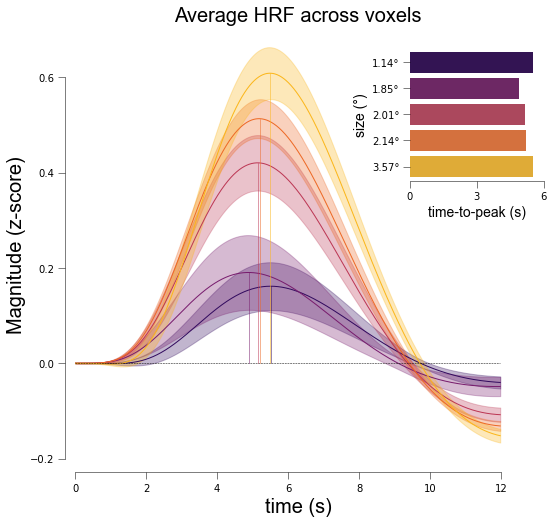

In [51]:
nd_fit.plot_average_per_event(xkcd=plot_xkcd, 
                              alpha=0.2,  
                              x_label="time (s)",
                              y_label="Magnitude (z-score)",
                              add_hline='default',
                              sns_trim=True,
                              ttp=True,
                              lim=[0, 6],
                              ticks=[0, 3, 6],
                              ttp_lines=True,
                              y_label2="size (°)",
                              x_label2="time-to-peak (s)", 
                              ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fit.cond],
                              add_labels=True,                              
                              cmap='inferno')


Or `full-with half maximum` (FWHM)

[4.43726719700012, 4.430224630545845, 4.467938096709151, 4.468970595153457, 4.440331121612187]


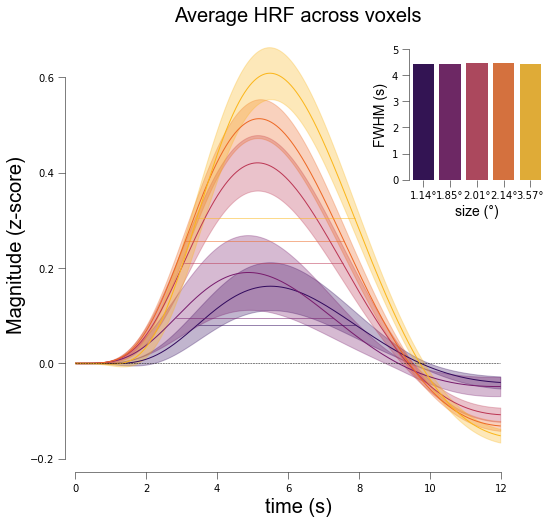

In [52]:
nd_fit.plot_average_per_event(xkcd=plot_xkcd, 
                              alpha=0.2,  
                              x_label="time (s)",
                              y_label="Magnitude (z-score)",
                              add_hline='default',
                              sns_trim=True,
                              fwhm=True,
                              fwhm_lines=True,
                              lim=[0,5],
                              ticks=[i for i in range(6)],
                              fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fit.cond],
                              add_labels=True,
                              x_label2="size (°)",
                              y_label2="FWHM (s)",                              
                              cmap='inferno')


We can also plot all events for individual voxel in the dataframe (mind you, if you have 720 voxels, you'll get that many plots. That's a bit of an overkill):

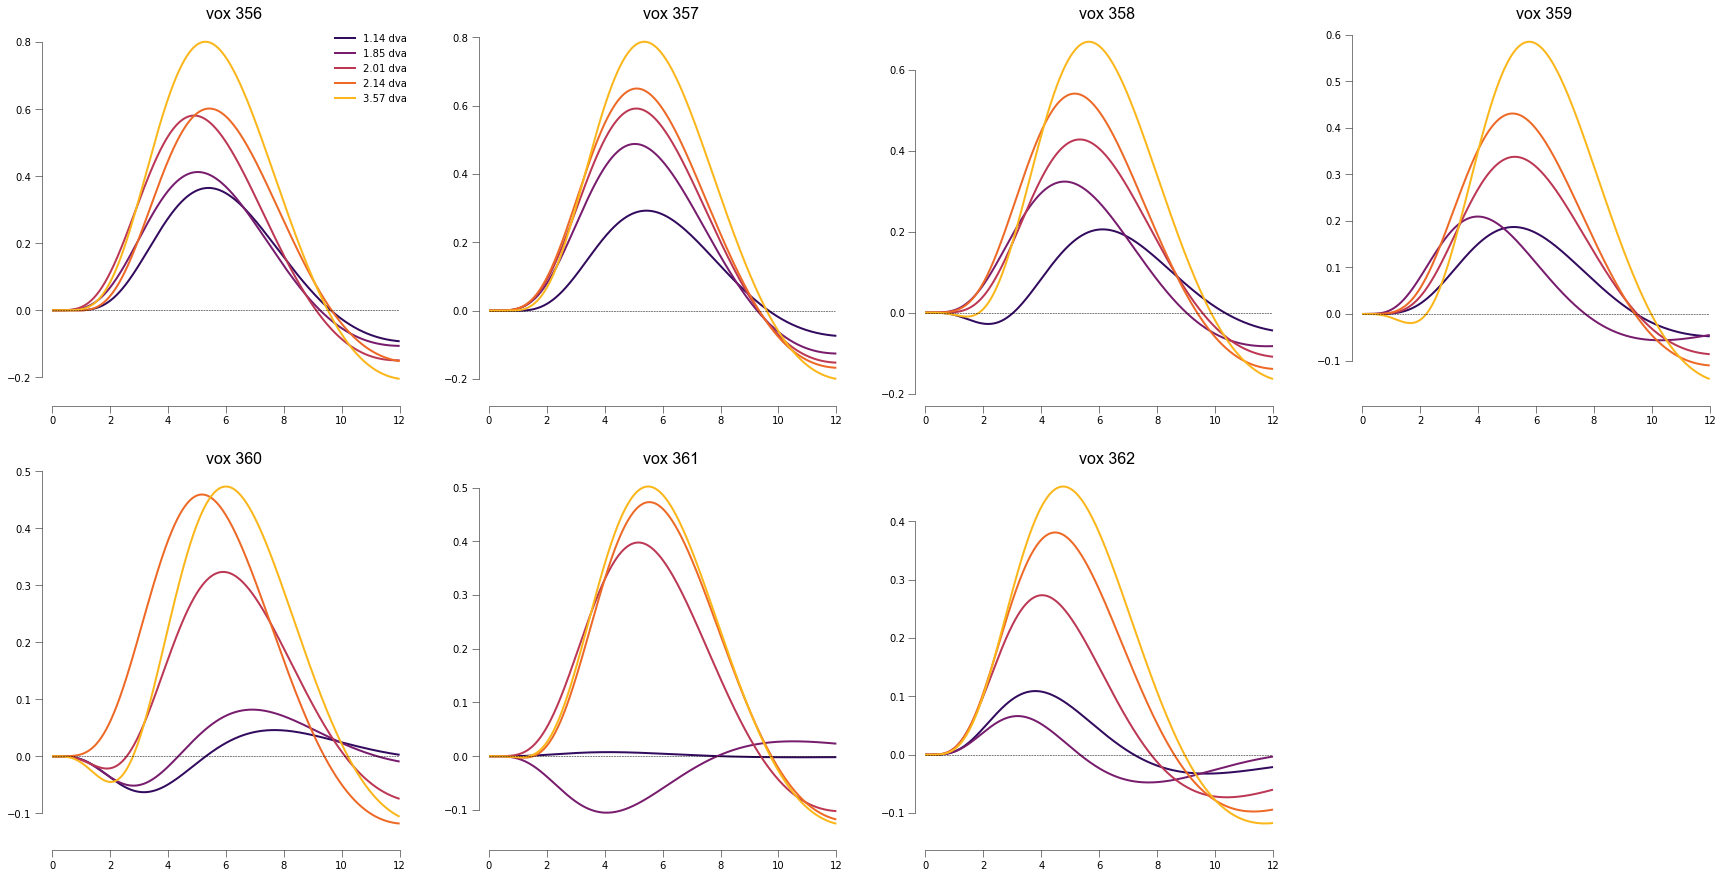

In [27]:
nd_fit.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=[f"{round(float(ii),2)} dva" for ii in nd_fit.cond], 
                              wspace=0.2,
                              sns_trim=True,
                              cmap="inferno",
                              line_width=2)

Above, we defined each stimulus size as separate event. To investigate a global response, we can also lump all the events together using `lump_events=True`. This means we'll interpret *any* event as 1 event:

In [29]:
lumped = utils.NideconvFitter(df_ribbon,
                              df_onsets,
                              confounds=None,
                              basis_sets='fourier',
                              n_regressors=4,
                              lump_events=True,
                              TR=0.105,
                              interval=[0,12],
                              add_intercept=True,
                              verbose=True)

Selected 'fourier'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


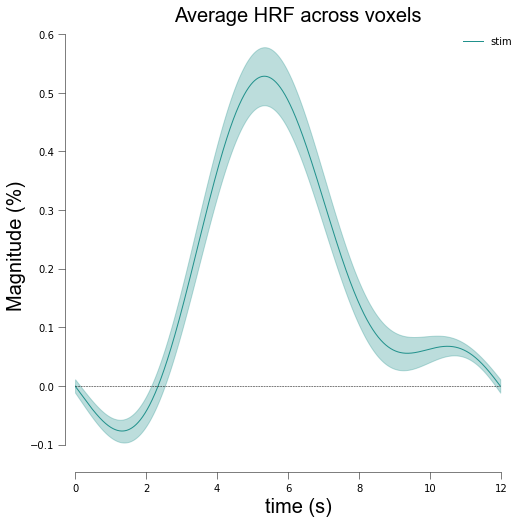

In [30]:
# plot average across voxels
lumped.plot_average_per_event(xkcd=plot_xkcd, 
                              labels=['stim'],
                              figsize=(8,8),
                              x_label="time (s)",
                              y_label="Magnitude (%)",
                              add_hline='default')


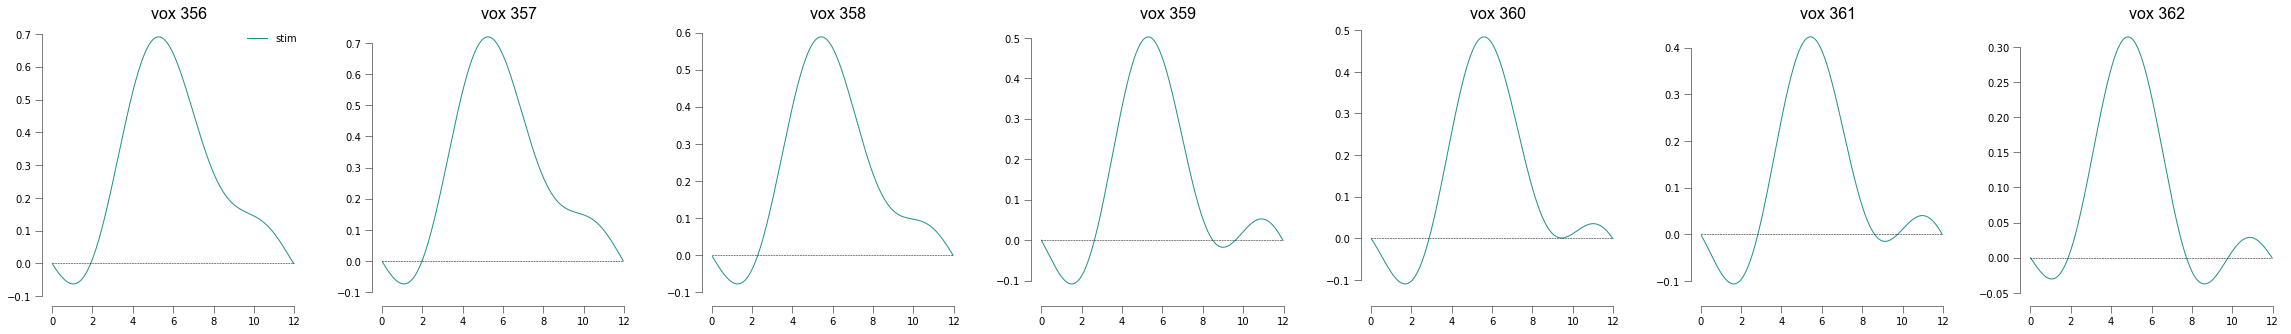

In [31]:
# plot individual voxels in separete figures
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              labels=['stim'], 
                              n_cols=7, 
                              figsize=(40,5),
                              wspace=0.3)

With this lumped-event model, we can also plot the HRFs across depth, independent of stimulus size (left plot). We can then extract the maximums of all HRFs and fit a polynomial to it, revealing a trend towards decreased HRF-amplitude when going from CSF/GM to GM/WM borders

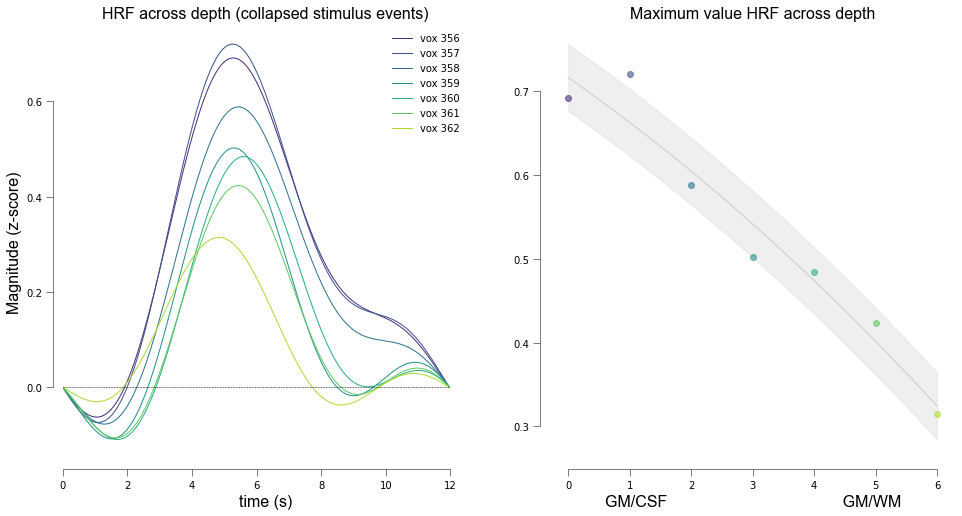

In [33]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(xkcd=plot_xkcd, 
                              n_cols=None, 
                              figsize=(8,8), 
                              axs=ax, 
                              labels=True,
                              title="HRF across depth (collapsed stimulus events)",
                              x_label="time (s)",
                              y_label="Magnitude (z-score)")

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(xkcd=plot_xkcd, 
                             axs=ax, 
                             title="Maximum value HRF across depth",
                             x_label="GM/CSF                                       GM/WM",
                             set_xlim_zero=False) #,
                            #  y_lim=[0.1,0.35])
